# DESC pointing stabiliy

In [1]:
import h5py;
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.optimize import curve_fit

### Plot settings 

In [2]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize' : (10,10)})

### Utility functions

In [3]:
def count_nans(array):
    return np.count_nonzero(np.isnan(array))  

## DAQ run with pointing change on focus paddle

In [4]:
run_number = 28497

data_dir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdf_filename = 'FLASH1_USER1-run'+str(run_number)+'.h5'
image_path = '/home/cpassow/DESC-commissioning/processed/fringes/fig/'

print(data_dir+hdf_filename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28497.h5


### Read and Plot Delay Stage Positions

In [5]:
hdf_file = h5py.File(data_dir+hdf_filename,'r')
motor_pos_fine = hdf_file['/FL1/Experiment/BL1/CAMP/DESC/Fine delay stage/position'][()]
motor_pos_coarse = hdf_file['/FL1/Experiment/BL1/CAMP/DESC/Coarse delay stage/position'][()]

print('NaNs: coarse ',count_nans(motor_pos_coarse),'| fine:',count_nans(motor_pos_fine))

NaNs: coarse  488 | fine: 373


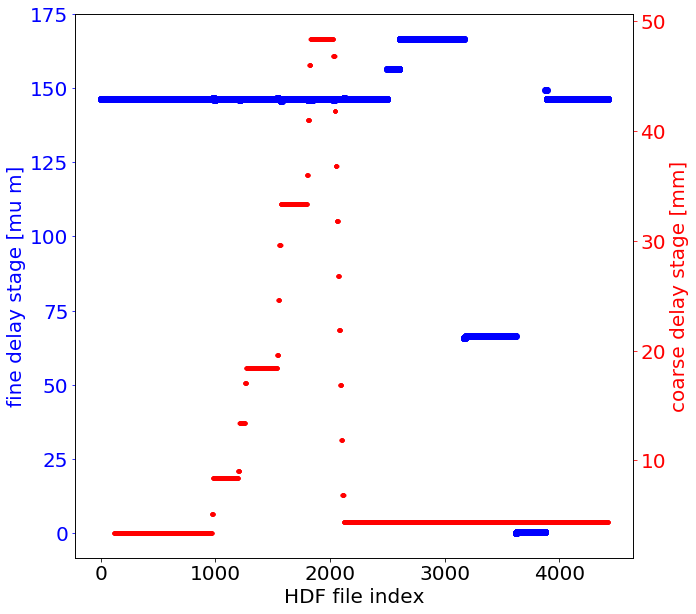

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(motor_pos_fine,'bo')
ax1.set_xlabel('HDF file index')
ax1.set_ylabel('fine delay stage [mu m]', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(motor_pos_coarse,'r.')
ax2.set_ylabel('coarse delay stage [mm]', color='r')
ax2.tick_params('y', colors='r')

plt.show()

* "balistic-like movement" of delay stages ?  
* 5 coarse delay movements  
* 5 fine delay movements

## Read Images from h5 file 

In [7]:
img = hdf_file['/FL1/Experiment/Camera/Focus microscope/image'][()]
print(type(img),'|',img.shape)

<class 'numpy.ndarray'> | (4800, 1280, 960)


In [8]:
integral = np.asarray([np.sum(img[index]) for index in range(0,img.shape[0])])

logic_map = (integral>1000)
res = [i for i, val in enumerate(logic_map) if val]
print('Number of blanks in the end:', len(logic_map)-res[-1])
print('Acutal Rate in dataset (without appended blanks): {0:.3f} '.format((len(res)/res[-1])))

Number of blanks in the end: 378
Acutal Rate in dataset (without appended blanks): 0.601 


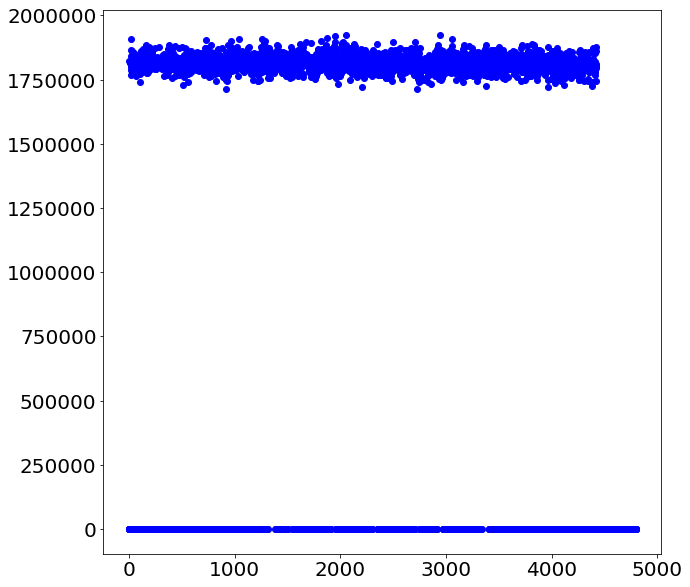

In [9]:
plt.figure()
plt.plot(integral,'bo')
plt.show()

# Example - Single Image

number of saturated pixel in raw image: 20
number of saturated pixel in ROI of image: 0


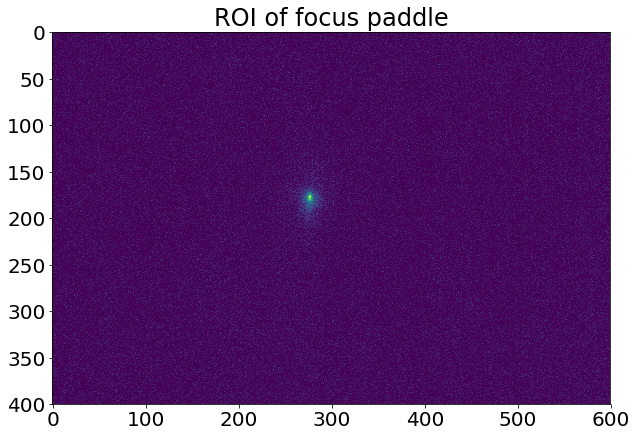

In [10]:
img_nummer = 0
zoom_height_top, zoom_height_down, zoom_width_left, zoom_width_right = 400, 800, 200, 800

example_img = img[img_nummer][zoom_height_top:zoom_height_down,zoom_width_left:zoom_width_right]

plt.figure()
plt.imshow(example_img)
plt.title('ROI of focus paddle')

print('number of saturated pixel in raw image:', len(img[img_nummer][img[img_nummer] > 254]))
print('number of saturated pixel in ROI of image:', len(example_img[example_img > 254]))

### Utility functions for fitting 

In [29]:
def gaus(x,a,x0,sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+ offset

def fit_params_gaus(x, y):
    n = np.sum(y)
    mean = np.sum(y * x) / n
    sigma= np.sqrt(np.sum(y * (x - mean) ** 2) / n)
    popt,pcov = curve_fit(gaus, x, y, p0=[1, mean, sigma, 0.0])
    return popt

def calc_center_of_gaus_fits(image):   
    center_x = fit_params_gaus(range(image.shape[1]), np.sum(image, axis=0))[1]
    center_y = fit_params_gaus(range(image.shape[0]), np.sum(image, axis=1))[1] 
    return center_x, center_y


### Visualize Lineouts and  Center of Gaus Fit

In [31]:
def calc_lineout_from_image(image):
    range_x = range(image.shape[1])
    range_y = range(image.shape[0])
    lineout_x = np.sum(image, axis=0)
    lineout_y = np.sum(image, axis=1)
    params_x = fit_params_gaus(range_x, lineout_x)
    params_y = fit_params_gaus(range_y, lineout_y)  
    return range_x, range_y, lineout_x, lineout_y, params_x, params_y

def add_lineout_plot(ax, lineout, range_dim, params, title = None):
    ax = ax
    ax.plot(lineout)
    ax.plot(range_dim,gaus(range_dim,*params),'r-')
    ax.set_title(title)
    ax.text(len(range_dim)*0.6,1200,'center: %.2f'%params[1])
    return ax

def visualize_lineout_from_image(image):
    range_x, range_y, lineout_x, lineout_y,params_x, params_y = calc_lineout_from_image(image)
    
    fig = plt.figure(figsize=(16,16))
    gs = gridspec.GridSpec(2, 2)
    ax = fig.add_subplot(gs[0, :])
    ax.imshow(example_img)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax1 = fig.add_subplot(gs[1, 0])
    add_lineout_plot(ax1, lineout_x, range_x,params_x, title='x projection')

    ax2 = fig.add_subplot(gs[1, 1])
    add_lineout_plot(ax2, lineout_y, range_y,params_y, title='y projection')

    plt.show()  


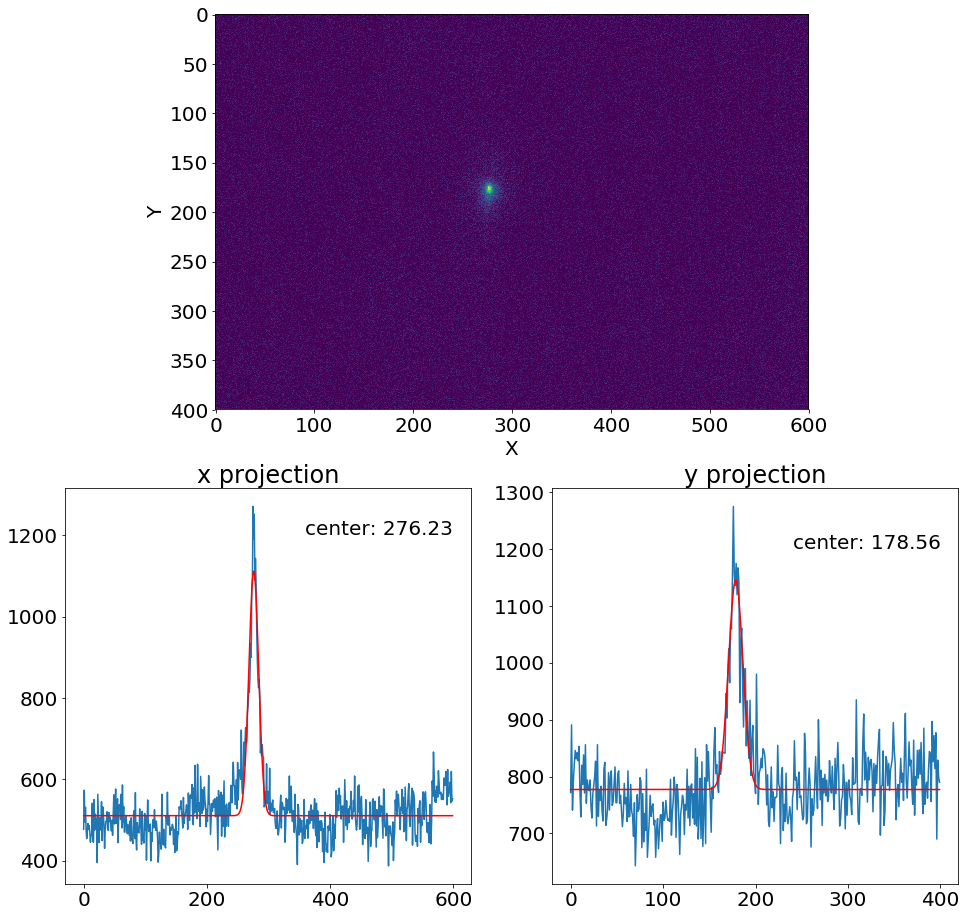

In [33]:
visualize_lineout_from_image(example_img)